In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

import qnmfits
import analytic_fit
import utils
import corner

from cmcrameri import cm

plt.rcParams.update(utils.rcparams)

In [2]:
t0_M = pd.read_csv('../data/t0_data_30_to_100.csv', index_col=0)

In [3]:
ID = 1

sim_info = utils.load_cce_data(ID)
sim = sim_info['sim']
chif = sim.chif_mag
Mf = sim.Mf

In [4]:
def get_stable_window(sim, modes, chif, Mf, t0_list, window_size=10):

    C_at_peak_list = []
    for t0_trial in t0_list:
        bf = qnmfits.ringdown_fit(
            sim.times,
            sim.h[2,2],
            modes=modes,
            Mf=Mf,
            chif=chif,
            t0=t0_trial,
            t0_method='closest',
            T=100
        )
        C_at_peak = []
        for C, omega in zip(bf['C'], bf['frequencies']):
            C_at_peak.append(C*np.exp(-1j*omega*(-t0_trial)))
        C_at_peak_list.append(C_at_peak)

    best_windows = []

    for i_mode in range(len(modes)):

        A_at_peak_list = np.abs([C[i_mode] for C in C_at_peak_list])
        phi_at_peak_list = np.angle([C[i_mode] for C in C_at_peak_list])

        best_std = np.inf
        best_window_start = 0

        for i in range(len(t0_list)-window_size):
            window_amp = A_at_peak_list[i:i+window_size]
            window_phase = phi_at_peak_list[i:i+window_size]
            std_amp = np.std(window_amp)
            std_phase = np.std(window_phase)
            std = std_amp + std_phase
            if std < best_std:
                best_std = std
                best_window_start = i

        A_at_peak_stable = A_at_peak_list[best_window_start:best_window_start+window_size]
        phi_at_peak_stable = phi_at_peak_list[best_window_start:best_window_start+window_size]
        C_stable_times = t0_list[best_window_start:best_window_start+window_size]

        A_at_peak_bestfit = np.mean(A_at_peak_stable)
        phi_at_peak_bestfit = np.mean(phi_at_peak_stable)
        time_bestfit = np.mean(C_stable_times)

        best_windows.append({
            'A_bestfit': A_at_peak_bestfit,
            'phi_bestfit': phi_at_peak_bestfit,
            'time_bestfit': time_bestfit,
            'A_stable': A_at_peak_stable,
            'phi_stable': phi_at_peak_stable,
            'times_stable': C_stable_times,
            'A_peak': A_at_peak_list,
            'phi_peak': phi_at_peak_list,
            't0_list': t0_list,
            'mode': modes[i_mode],
        })

    return best_windows

In [5]:
best_windows = get_stable_window(
    sim,
    modes=[(2,2,0,1), (3,2,0,1)],
    chif=chif,
    Mf=Mf,
    t0_list=np.linspace(-10, 100, 111),
    window_size=10
)

In [6]:
analysis_mask = (sim.times >= - 20) & (sim.times <= 100)
analysis_times = sim.times[analysis_mask]

A320_at_peak_bestfit = best_windows[1]['A_bestfit']
phi320_at_peak_bestfit = best_windows[1]['phi_bestfit']
omega_320 = qnmfits.qnm.omega(3, 2, 0, 1, chif=chif, Mf=Mf)

analysis_mask = (sim.times >= - 20) & (sim.times <= 100)
analysis_times = sim.times[analysis_mask]

h320 = A320_at_peak_bestfit*np.exp(1j*phi320_at_peak_bestfit) \
    * np.exp(-1j*omega_320*(analysis_times))

In [7]:
N = 8
T = 100
t0 = t0_M[str(ID)].values[N]

modes = [(2,2,n,1) for n in range(N+1)]
omega = qnmfits.qnm.omega_list(modes, chif=chif, Mf=Mf)
sigma = np.abs(h320)[np.argmin(np.abs(analysis_times - t0))]

In [8]:
t0, sigma

(np.float64(-1.7187671779138327), np.float64(0.0038007979225539758))

In [9]:
ls_fit = qnmfits.ringdown_fit(
    sim.times,
    sim.h[2,2],
    modes=modes,
    Mf=Mf,
    chif=chif,
    t0=t0,
    t0_method='closest',
    T=T
)

In [10]:
ls_a = np.abs(ls_fit['C'])
ls_phi = np.angle(ls_fit['C'])
ls_a_phi = np.concatenate((ls_a, ls_phi))

In [11]:
data = {
    'plus': np.real(sim.h[2,2]),
    'cross': -np.imag(sim.h[2,2]),
}

In [12]:
analytic_samples, A_samples, phi_samples = analytic_fit.sample(
    times=sim.times,
    data=data,
    sigma=sigma*np.ones_like(sim.times),
    qnm_omegas=omega,
    t0=t0,
    t0_method='closest',
    T=T,
    reweight=False,
)

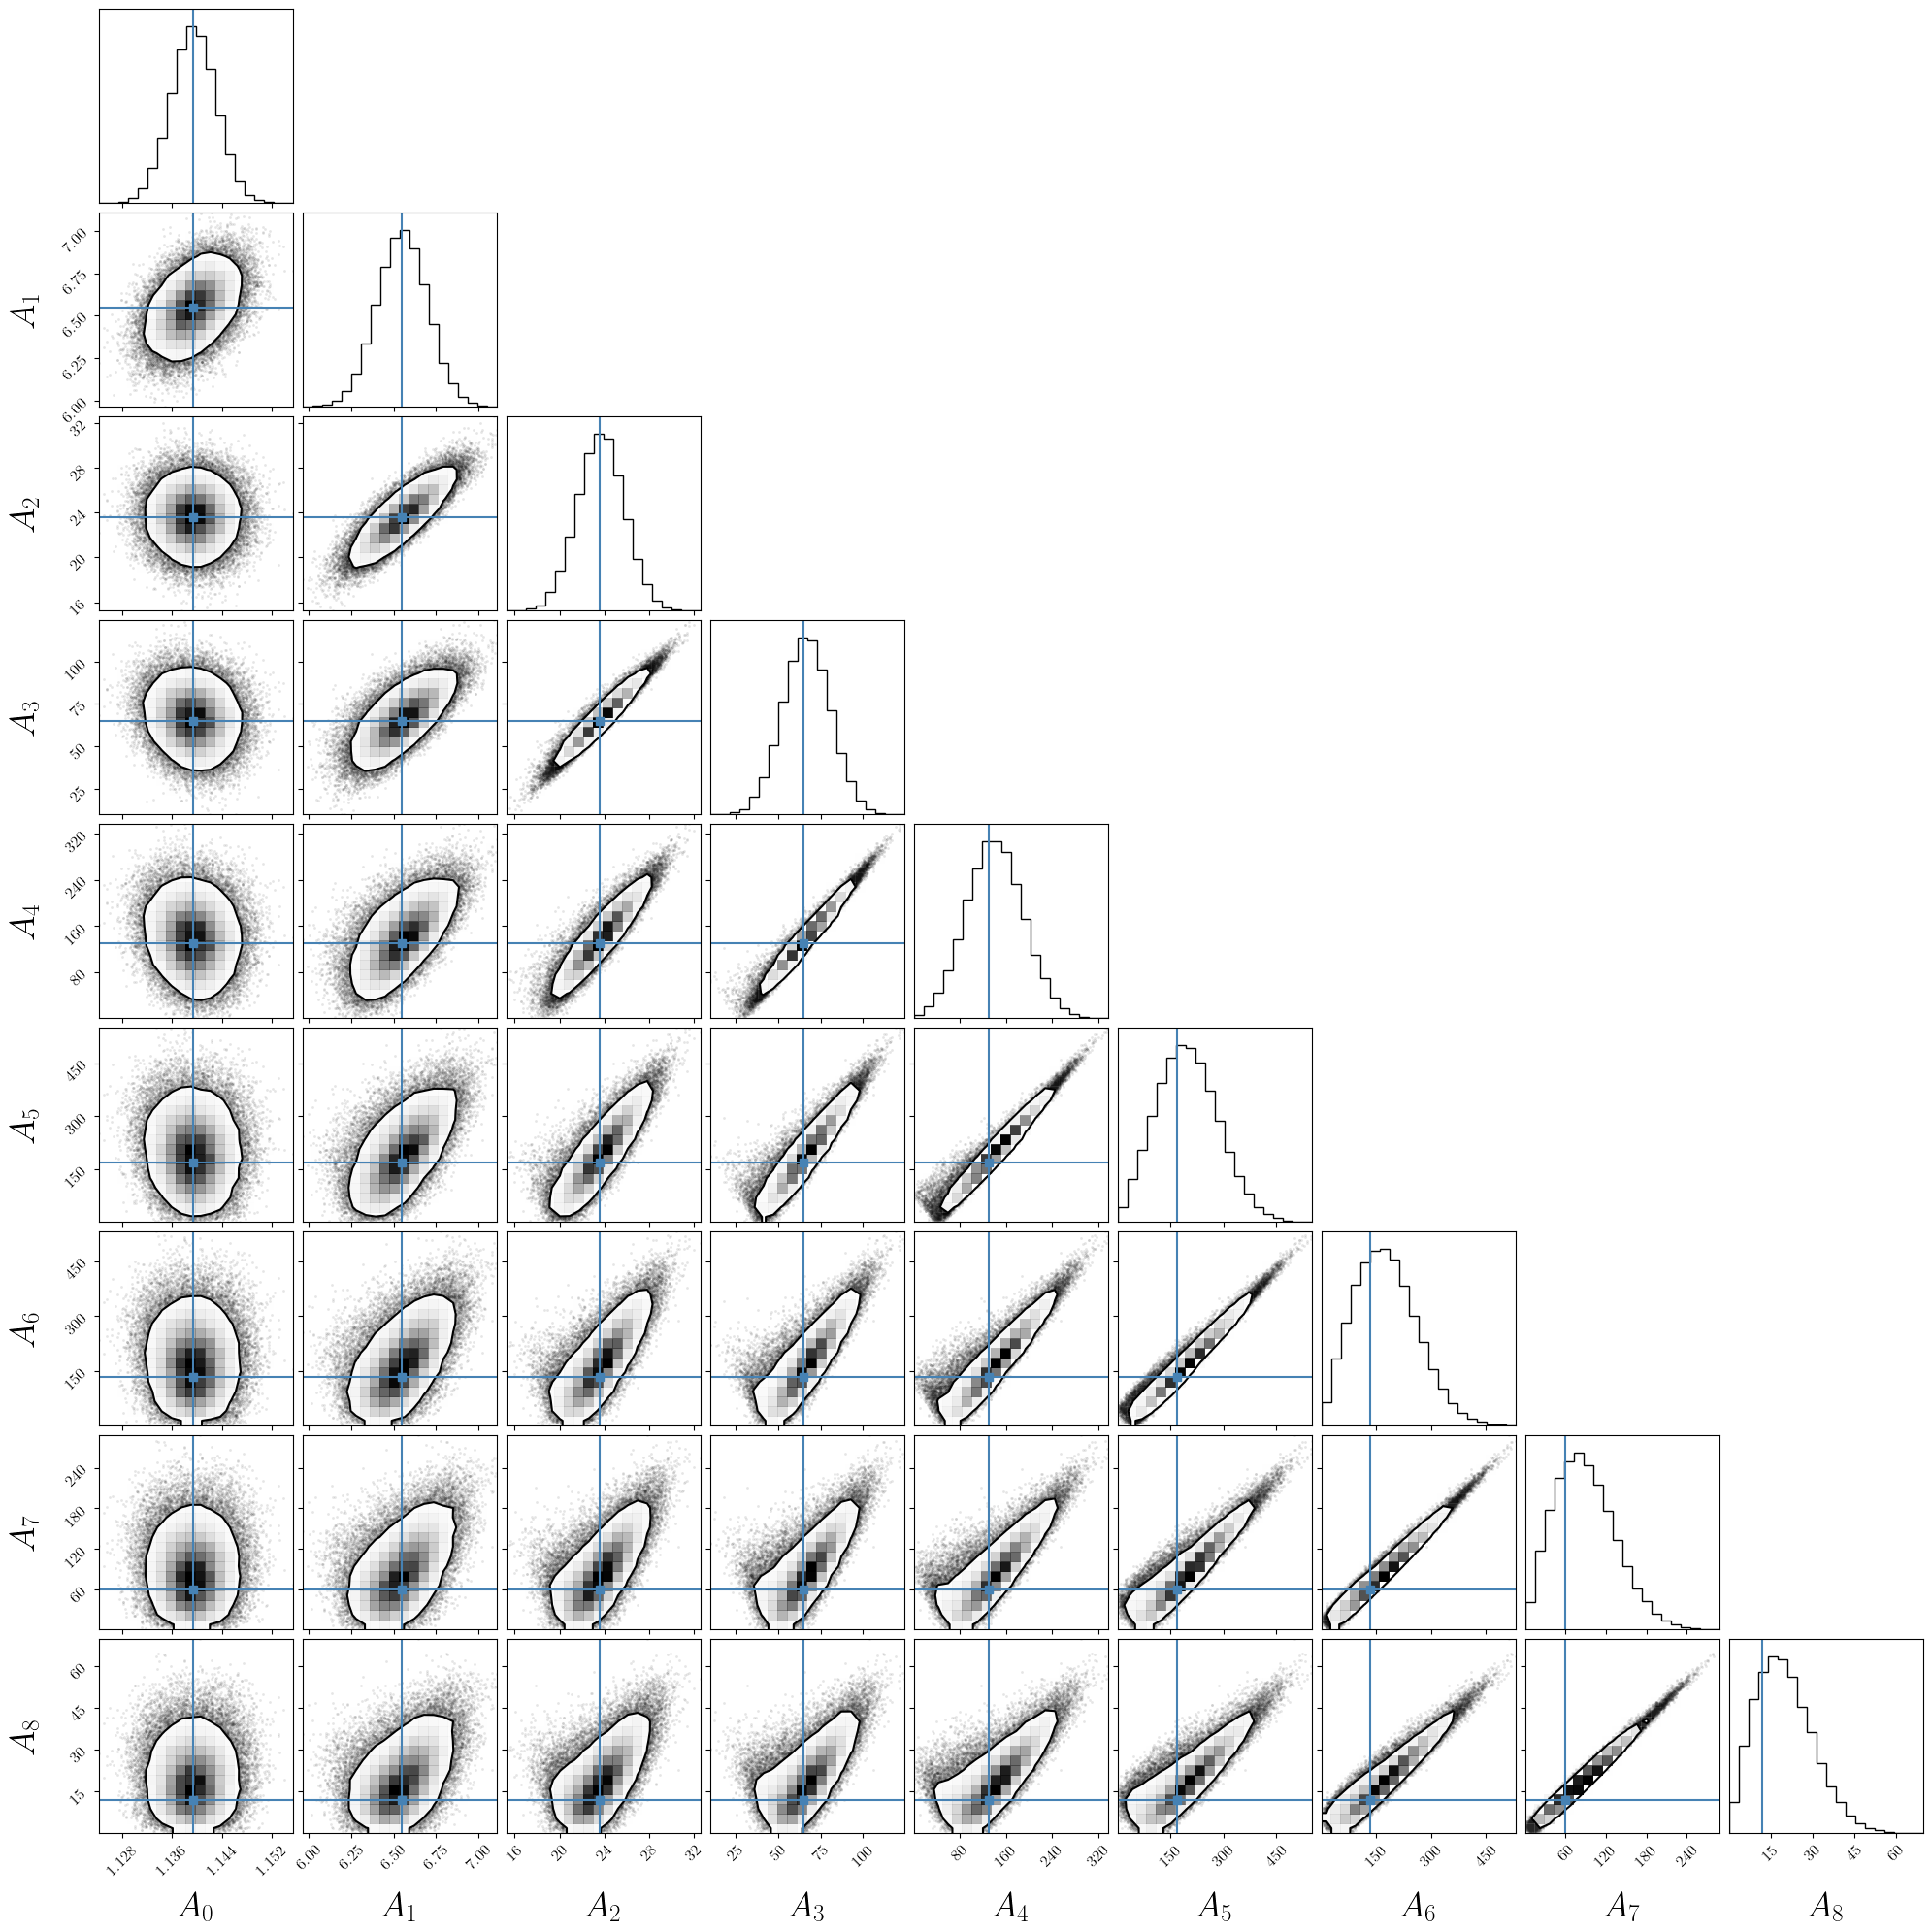

In [13]:
amp_labels = [rf'$A_{{{n}}}$' for (_,_,n,_) in modes]
phase_labels = [rf'$\phi_{{{n}}}$' for (_,_,n,_) in modes]
labels = amp_labels + phase_labels

fig = corner.corner(
    A_samples,
    levels=[0.9],
    labels=amp_labels,
    truths=ls_a,
    label_kwargs={"fontsize": 26},
)

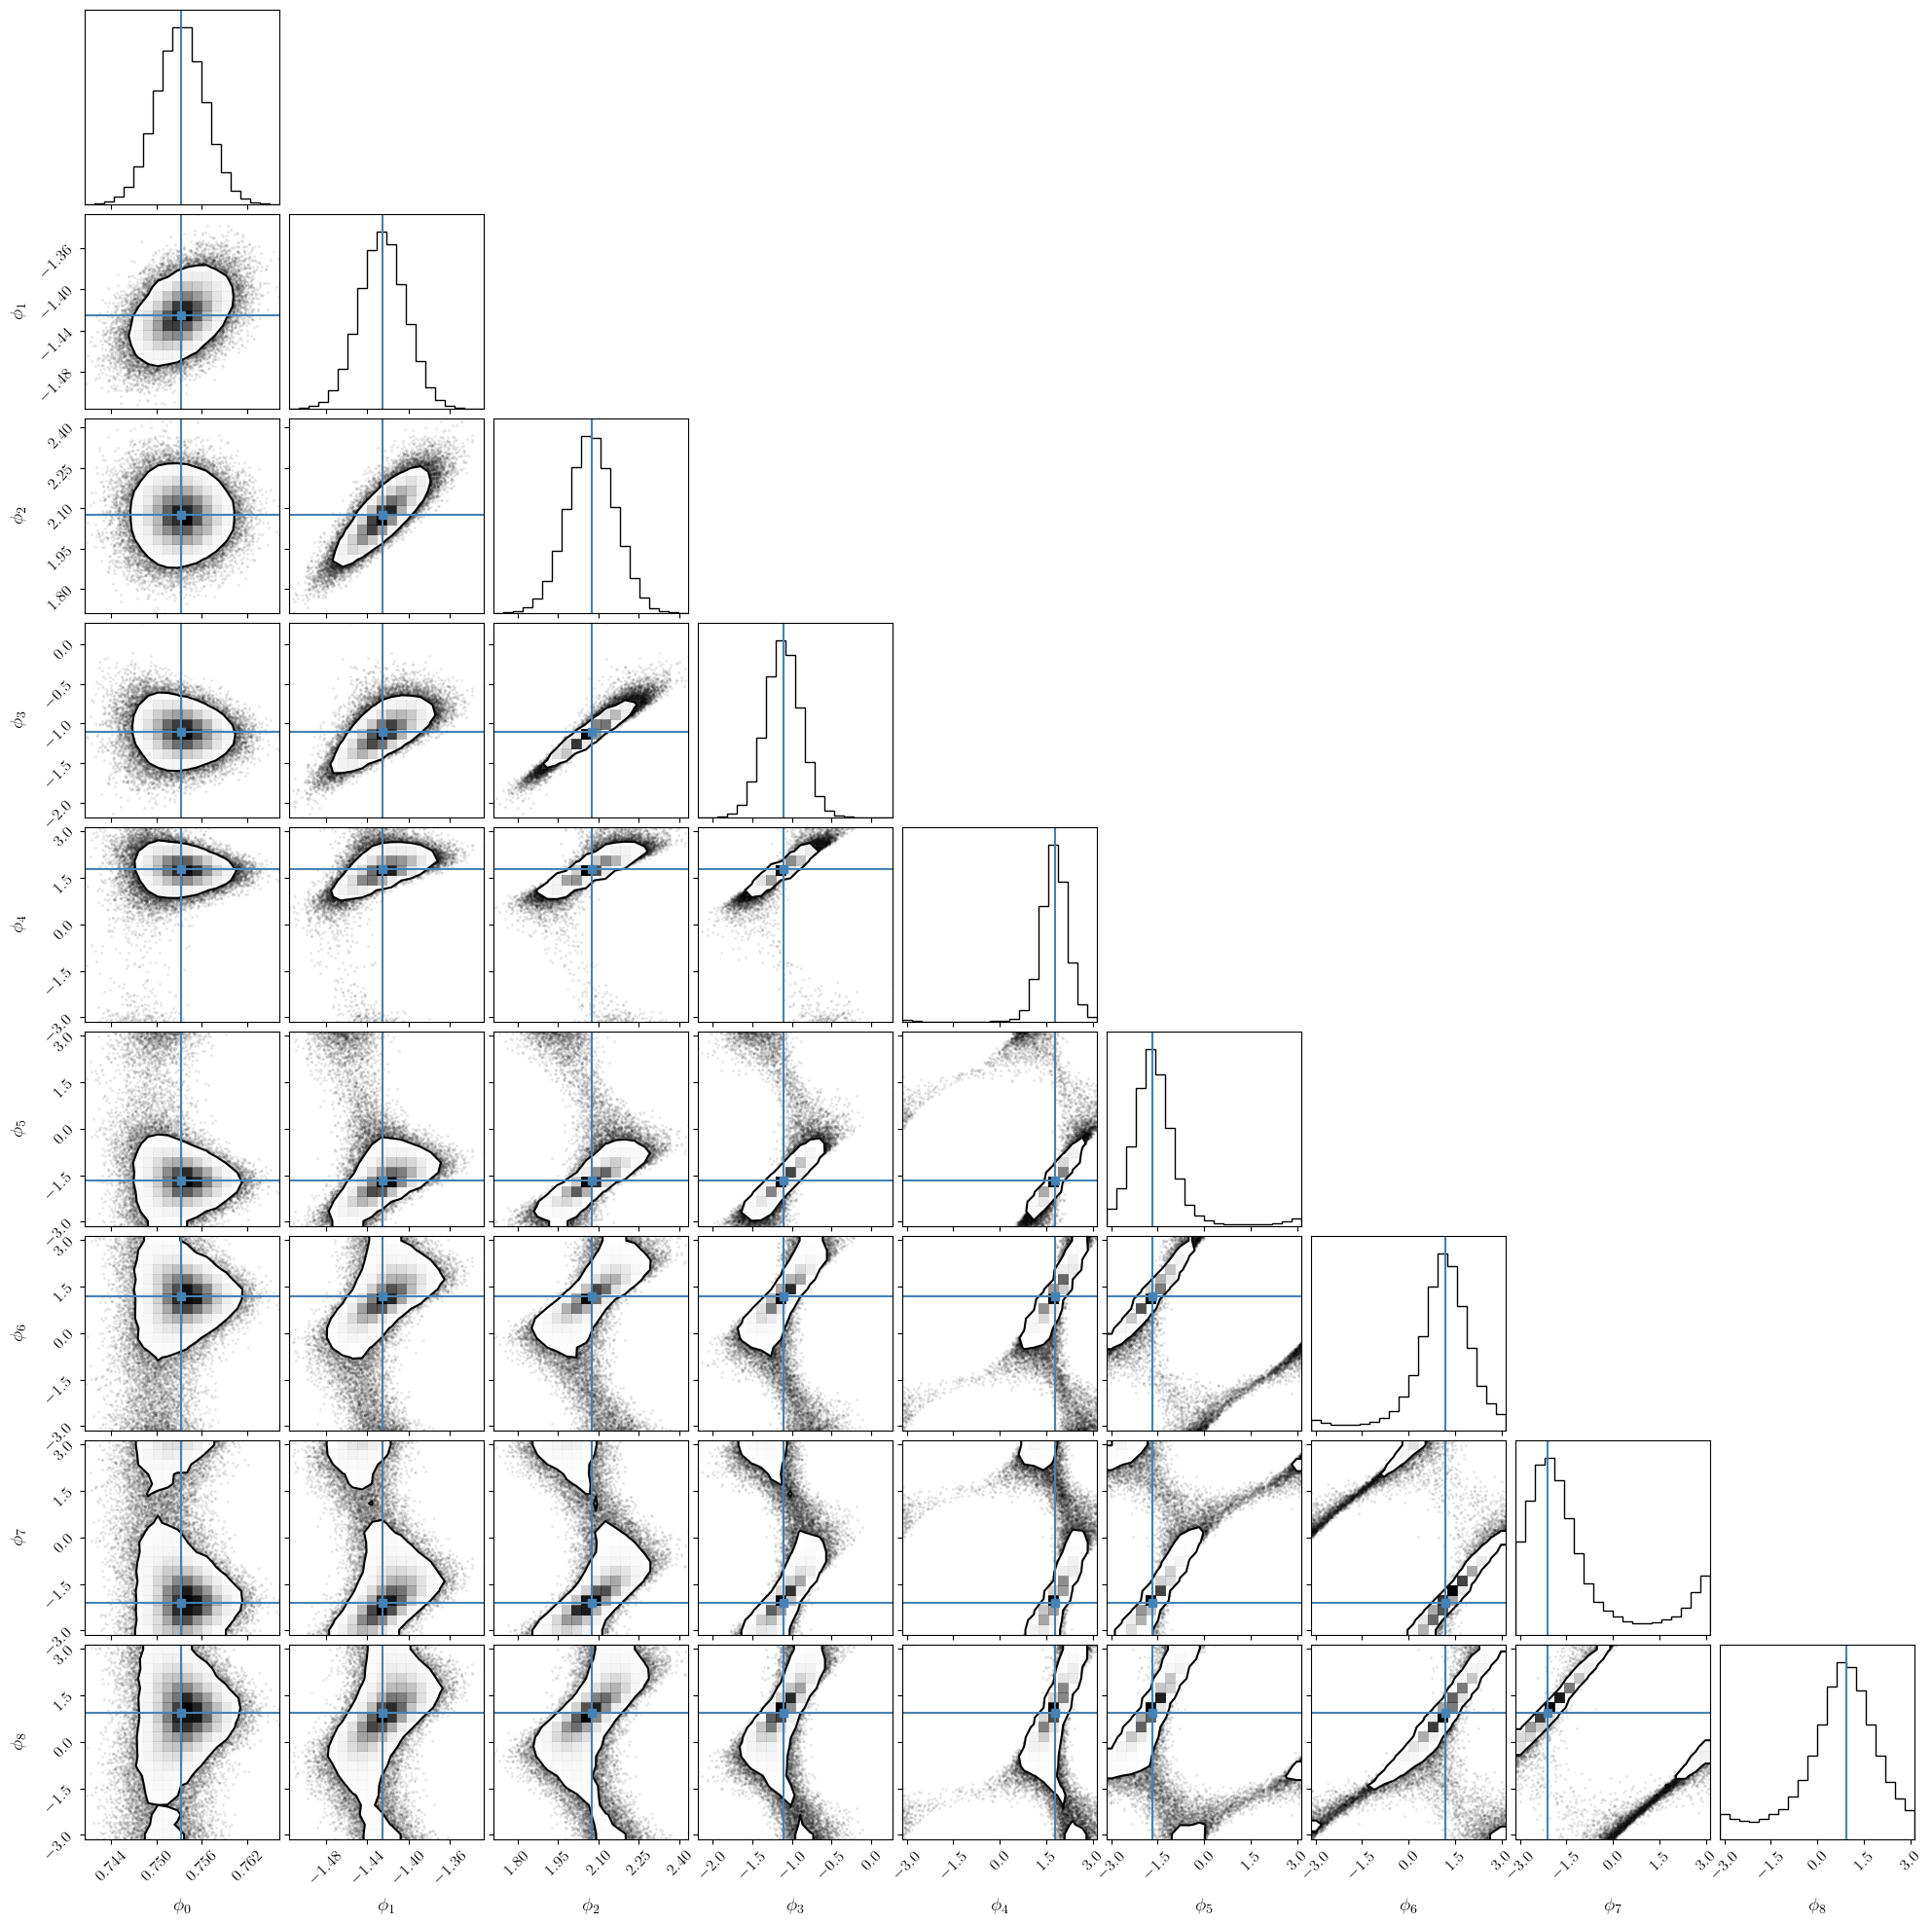

In [14]:
fig = corner.corner(
    phi_samples,
    levels=[0.9],
    labels=phase_labels,
    truths=ls_phi,
)

In [15]:
unwrapped_phi_samples = phi_samples.copy()
for i in range(unwrapped_phi_samples.shape[1]):
    unwrapped_phi_samples[:,i] = analytic_fit.unwrap(unwrapped_phi_samples[:,i])

In [16]:
shift = unwrapped_phi_samples[0] - phi_samples[0]

In [17]:
ls_phi_shifted = ls_phi + shift

In [18]:
ls_phi_shifted[7] += 2*np.pi

In [19]:
unwrapped_phi_samples[:,0] += 2*np.pi
ls_phi_shifted[0] += 2*np.pi

In [20]:
unwrapped_phi_samples[:,1] += 2*np.pi
ls_phi_shifted[1] += 2*np.pi

In [21]:
unwrapped_phi_samples[:,2] += 2*np.pi
ls_phi_shifted[2] += 2*np.pi

In [22]:
unwrapped_phi_samples[:,3] += 2*np.pi
ls_phi_shifted[3] += 2*np.pi

In [23]:
unwrapped_phi_samples[:,4] += 2*np.pi
ls_phi_shifted[4] += 2*np.pi

In [24]:
unwrapped_phi_samples[:,5] += 2*np.pi
ls_phi_shifted[5] += 2*np.pi

In [25]:
unwrapped_phi_samples[:,6] += 2*np.pi
ls_phi_shifted[6] += 2*np.pi

In [26]:
unwrapped_phi_samples[:,7] += 2*np.pi
ls_phi_shifted[7] += 4*np.pi

In [27]:
unwrapped_phi_samples[:,8] += 2*np.pi
ls_phi_shifted[8] += 2*np.pi

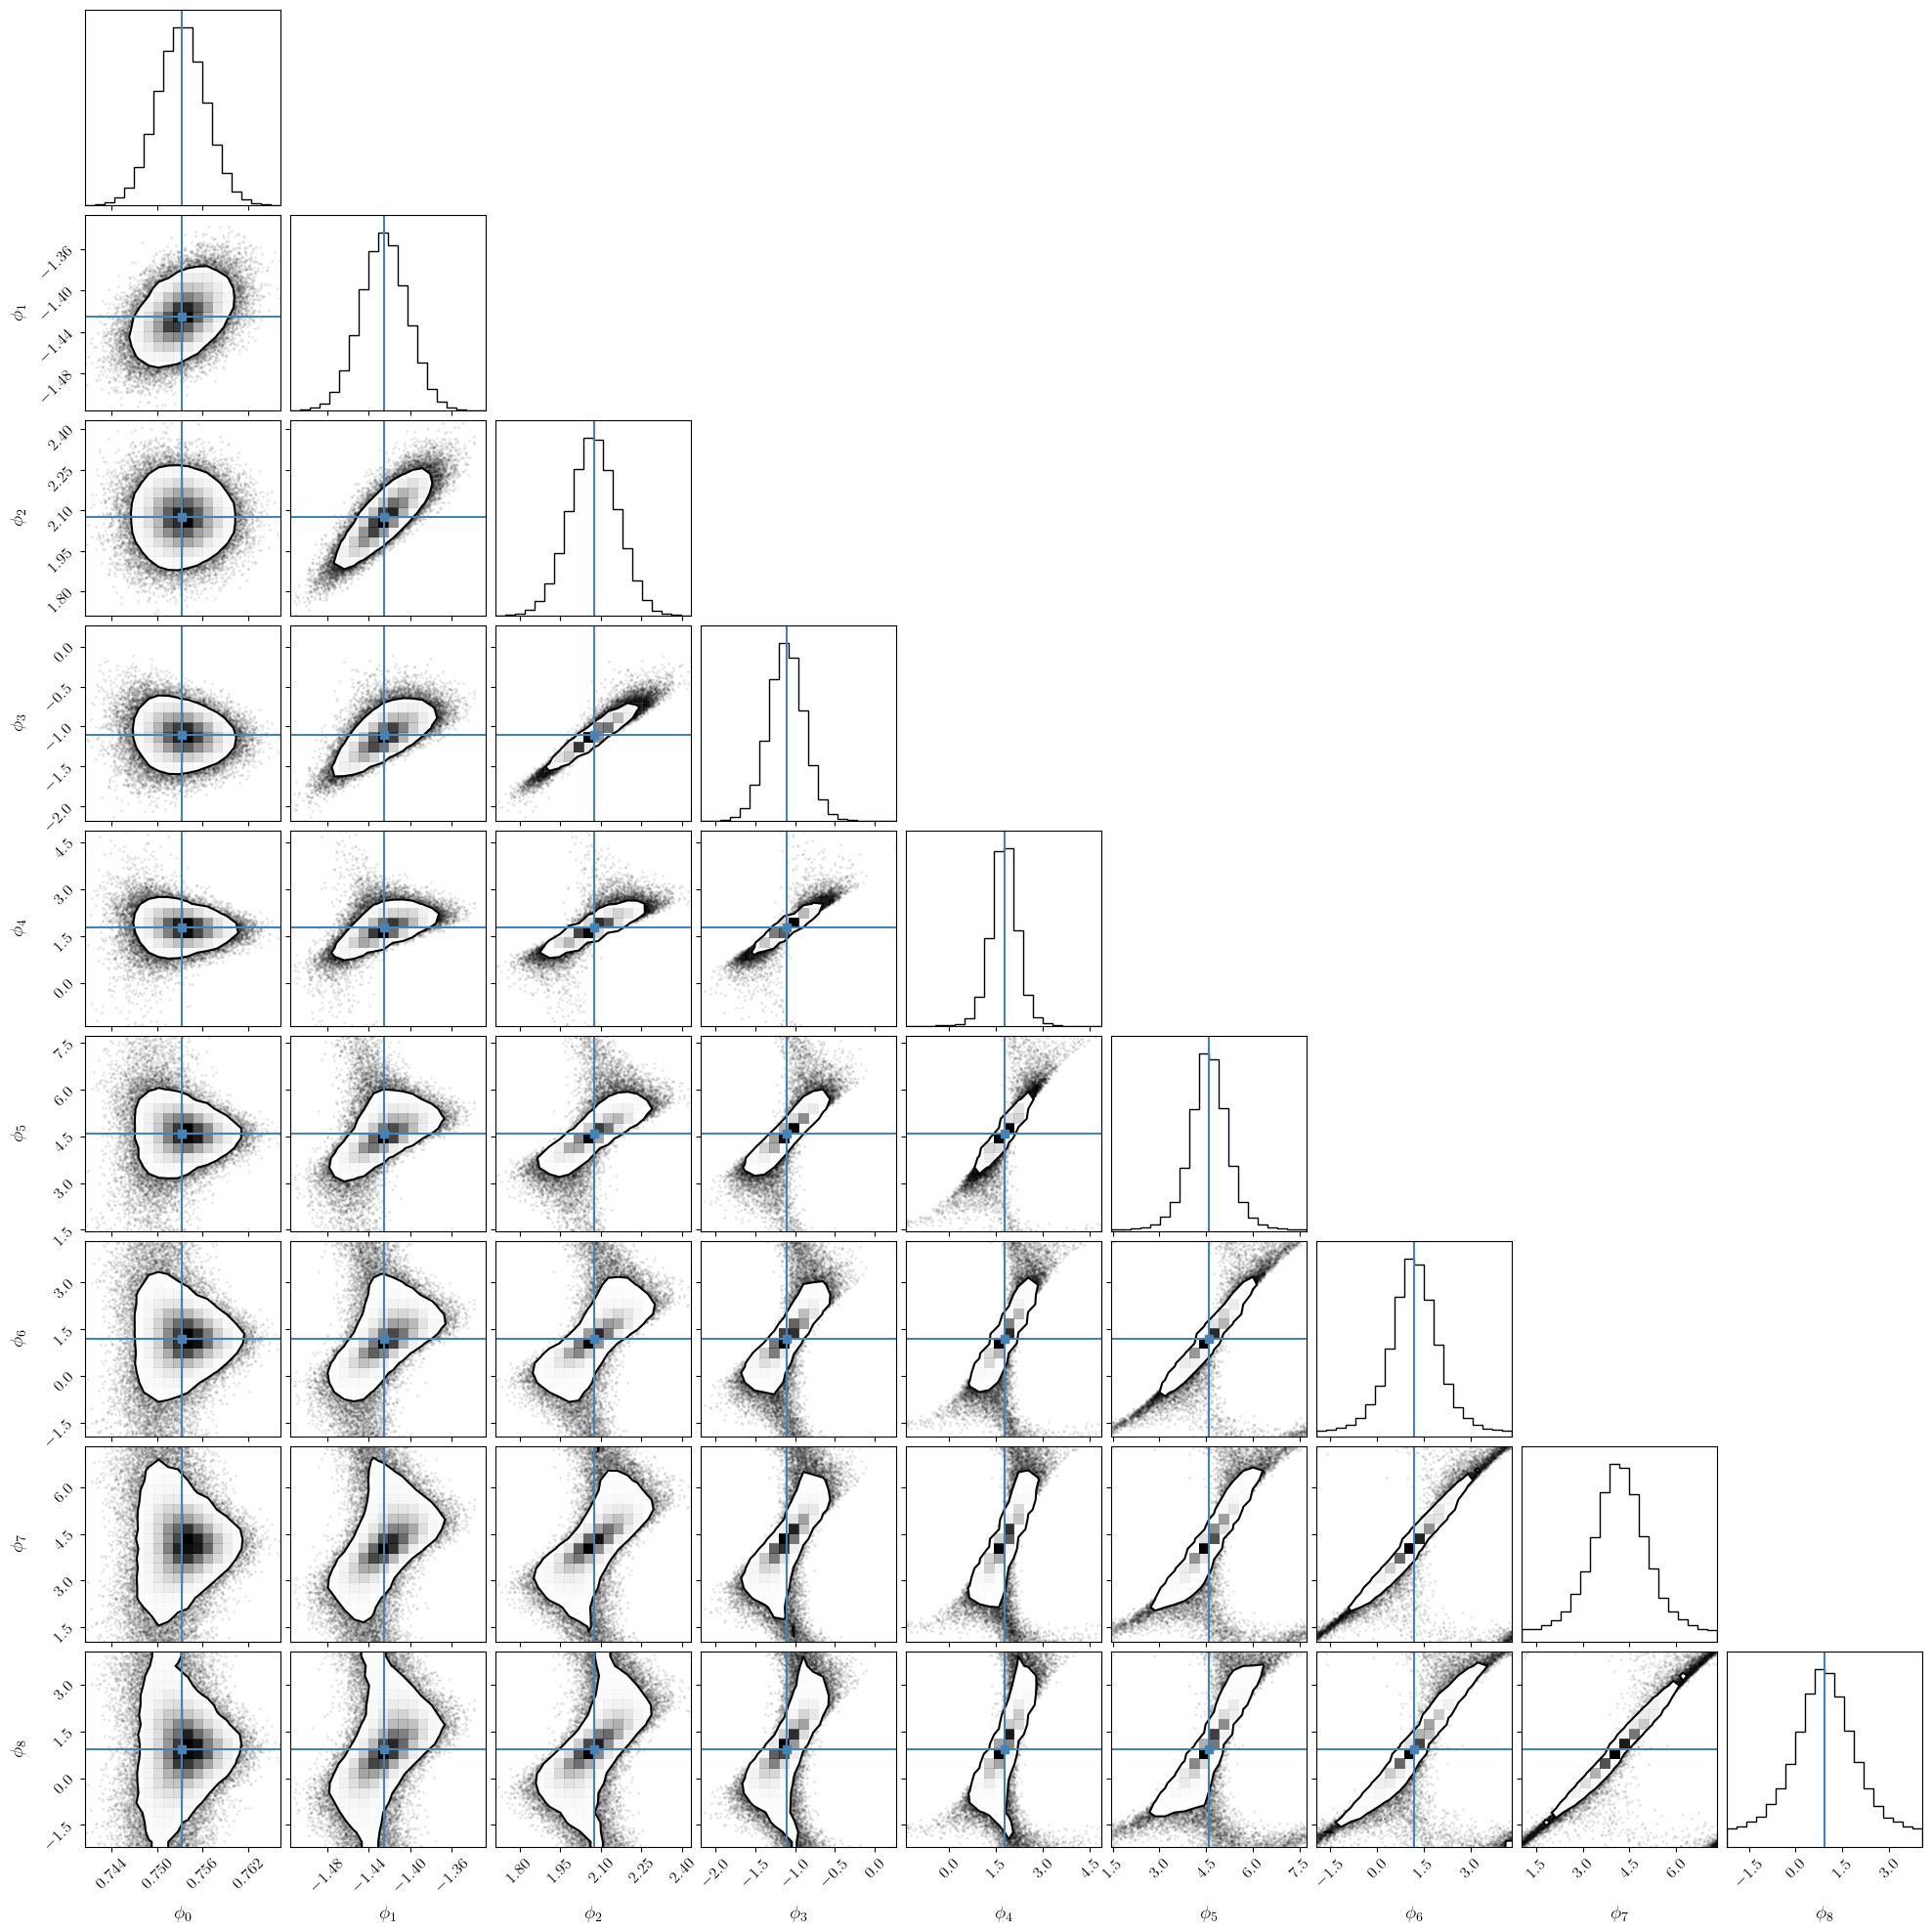

In [28]:
fig = corner.corner(
    unwrapped_phi_samples,
    levels=[0.9],
    labels=phase_labels,
    truths=ls_phi_shifted,
)

In [29]:
def shrink_hexagons(hexbin_obj, shrink=0.8):
    """
    Shrink the size of hexagons in a matplotlib hexbin plot.

    Parameters
    ----------
    hexbin_obj : PolyCollection
        The object returned by plt.hexbin().
    shrink : float, optional
        Scale factor for shrinking. 
        1.0 leaves them unchanged, 
        <1.0 makes them smaller, 
        >1.0 makes them larger.
    """
    # Get original hexagon vertices
    verts = hexbin_obj.get_paths()[0].vertices
    # Find center of hexagon (mean of vertices)
    center = verts.mean(axis=0)
    # Rescale around the center
    new_verts = (verts - center) * shrink + center
    # Apply back to all hexagons
    hexbin_obj.set_verts([new_verts])

In [30]:
phi_lims = {}
for i, entry in enumerate(unwrapped_phi_samples.T):
    phi_min = np.min(entry)
    phi_max = np.max(entry)
    phi_lims[i] = (phi_min, phi_max)

In [31]:
A_ticks = {
    0: [1.13, 1.14, 1.15],
    1: [6, 6.5, 7],
    2: [15, 20, 25, 30],
    3: [50, 100],
    4: [0, 100, 200, 300],
    5: [0, 250, 500],
    6: [0, 250, 500],
    7: [0, 100, 200, 300],
    8: [0, 25, 50, 75]
}

In [32]:
phi_ticks = {
    0: [0.75, 0.76],
    1: [-1.5, -1.4],
    2: [1.75, 2.00, 2.25],
    3: [-2, -1, 0],
    4: [0.0, 2.5],
    5: [2.5, 5.0, 7.5],
    6: [0.0, 2.5],
    7: [2.5, 5.0],
    8: [0.0, 2.5]
}

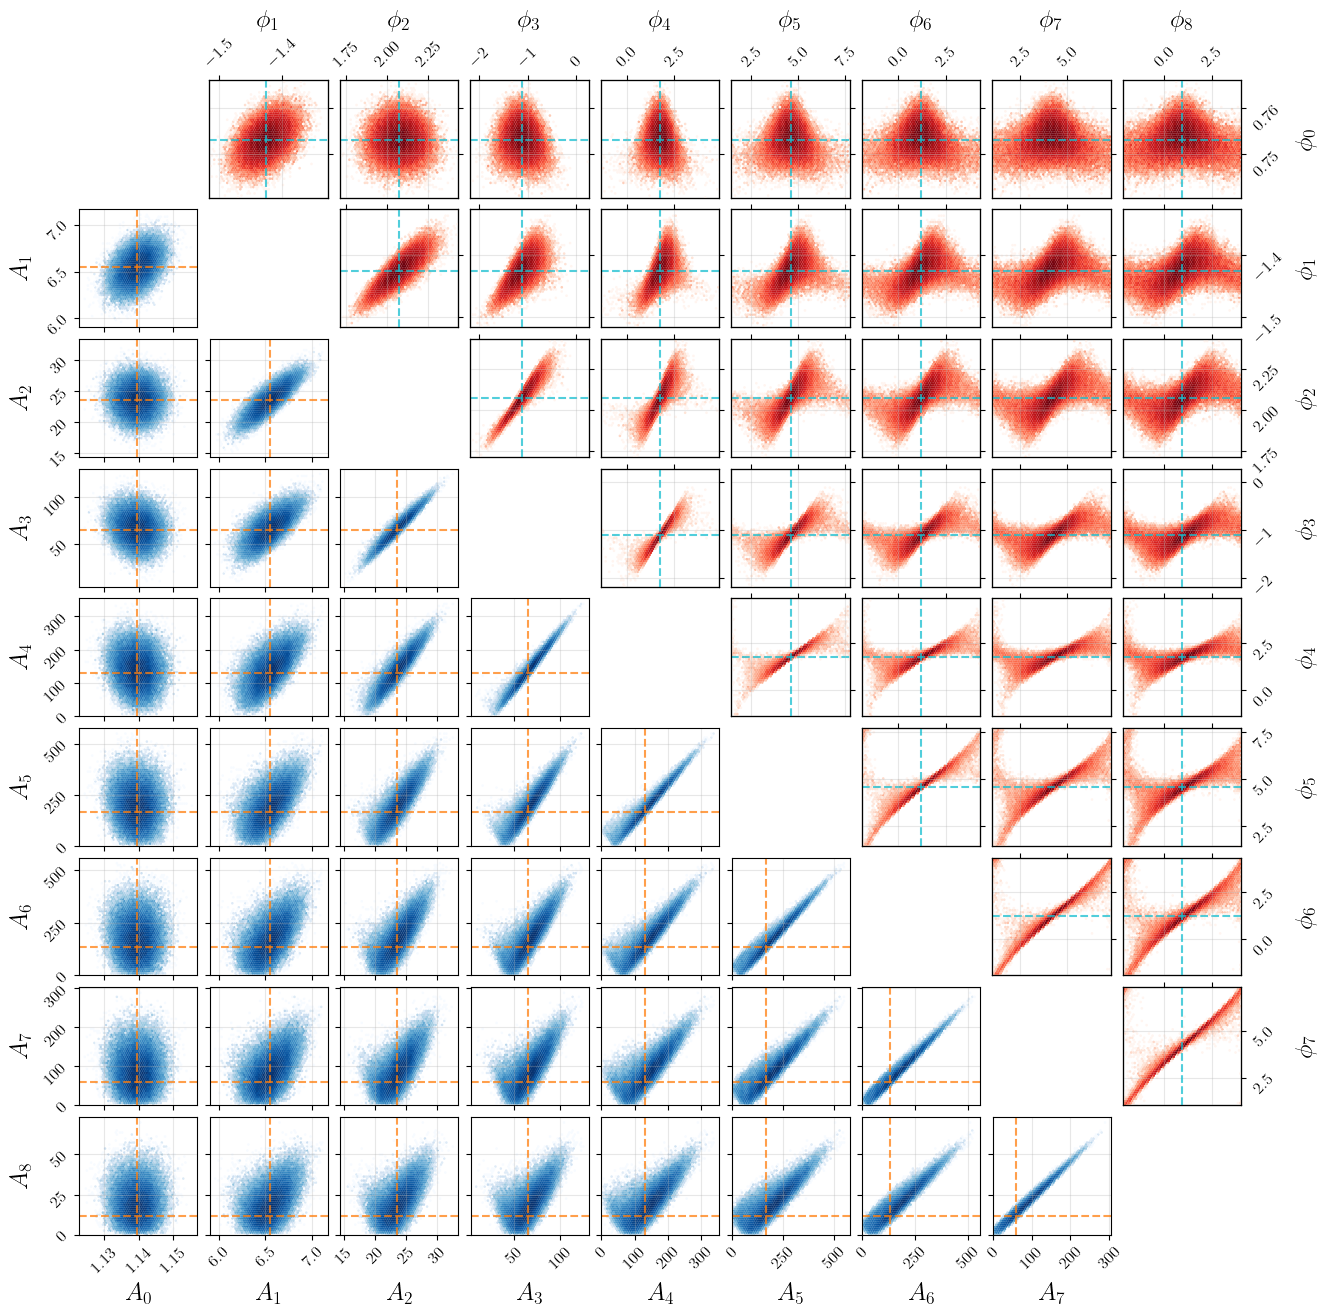

In [33]:
from matplotlib import colormaps
cmap_A = colormaps['Blues']
cmap_phi = colormaps['Reds']

fig, axs = plt.subplots(N+1, N+1, figsize=(15,15))
fig.subplots_adjust(wspace=0.1, hspace=0.1)

for ax in axs.flatten():
    ax.set_box_aspect(1)

for i in range(N+1):
    axs[i,i].set_axis_off()

labelpad = 0.1

for i in range(1, N+1):
    axs[i,0].set_ylabel(amp_labels[i], fontsize=18)
    axs[i,0].tick_params(axis='y', which='major', labelsize=12, rotation=45)
    axs[i,0].yaxis.set_label_coords(-0.3 - labelpad, 0.5)
    axs[i,0].set_yticks(A_ticks[i])

for j in range(N):
    axs[N,j].set_xlabel(amp_labels[j], fontsize=18)
    axs[N,j].tick_params(axis='x', which='major', labelsize=12, rotation=45)
    axs[N,j].xaxis.set_label_coords(0.5, -0.3 - labelpad)
    axs[N,j].set_xticks(A_ticks[j])

for i in range(N):
    for j in range(i+1):
        axs[i,j].set_xticks(A_ticks[j])
        axs[i,j].set_xticklabels([])

for i in range(N+1):
    for j in range(1, i):
        axs[i,j].set_yticks(A_ticks[i])
        axs[i,j].set_yticklabels([])

for i in range(1, N+1):
    for j in range(i):
        x = A_samples[:,j]
        y = A_samples[:,i]
        hb = axs[i,j].hexbin(x, y, gridsize=50, cmap=cmap_A, bins='log', rasterized=True)
        shrink_hexagons(hb, shrink=0.5)


for j in range(N):
    lim = axs[N, j].get_xlim()
    if lim[0] < 0:
        lim = (0, lim[1])
    for i in range(j+1, N+1):
        axs[i,j].set_xlim(lim)

for i in range(1, N):
    lim = axs[N, i].get_xlim()
    for j in range(0, i):
        axs[i,j].set_ylim(lim)

lim = axs[N, 0].get_ylim()
if lim[0] < 0:
    lim = (0, lim[1])
for j in range(0, N):
    axs[N,j].set_ylim(lim)

for i in range(1, N+1):
    for j in range(i):
        axs[i,j].axvline(ls_a[j], color='C1', ls='--', lw=1.5, alpha=0.75)
        axs[i,j].axhline(ls_a[i], color='C1', ls='--', lw=1.5, alpha=0.75)

for i in range(1, N+1):
    for j in range(i):
        axs[i,j].grid(alpha=0.3)

twin_axs = {}
twin_axs_x = {}
twin_axs_y = {}
for i in range(N):
    for j in range(i+1, N+1):
        twin_axs_x[i,j] = axs[i,j].twinx()
        twin_axs_y[i,j] = axs[i,j].twiny()
        axs[i,j].set_xticklabels([])
        axs[i,j].set_yticklabels([])
        axs[i,j].tick_params(axis='both', which='both', length=0)

for j in range(1, N+1):
    twin_axs_y[0,j].set_xlabel(phase_labels[j], fontsize=18, labelpad=7.5)
    twin_axs_y[0,j].tick_params(axis='x', which='major', labelsize=12, rotation=45)
    twin_axs_y[0,j].xaxis.set_label_coords(0.5, 1.45)
    twin_axs_y[0,j].set_xticks(phi_ticks[j])

for i in range(0, N):
    twin_axs_x[i,N].set_ylabel(phase_labels[i], fontsize=18, labelpad=7.5)
    twin_axs_x[i,N].tick_params(axis='y', which='major', labelsize=12, rotation=45)
    twin_axs_x[i,N].yaxis.set_label_coords(1.45, 0.5)
    twin_axs_x[i,N].set_yticks(phi_ticks[i])

for i in range(1, N+1):
    for j in range(i+1, N+1):
        twin_axs_y[i,j].set_yticks(phi_ticks[i])
        twin_axs_y[i,j].set_xticklabels([])

for i in range(0, N+1):
    for j in range(i+1, N):
        twin_axs_x[i,j].set_yticks(phi_ticks[i])
        twin_axs_x[i,j].set_yticklabels([])

for i in range(N):
    for j in range(i+1, N+1):
        x = unwrapped_phi_samples[:,j]
        y = unwrapped_phi_samples[:,i]
        hb = twin_axs_x[i,j].hexbin(x, y, gridsize=50, cmap=cmap_phi, bins='log', rasterized=True)
        shrink_hexagons(hb, shrink=0.5)

for i in range(0, N):
    for j in range(i+1, N+1):
        axs[i,j].set_xlim(phi_lims[j])
        twin_axs_y[i,j].set_xlim(phi_lims[j])
        twin_axs_x[i,j].set_ylim(phi_lims[i])

for i in range(0, N):
    for j in range(i+1, N+1):
        twin_axs_x[i,j].grid(alpha=0.3)
        twin_axs_y[i,j].grid(alpha=0.3)

for i in range(0, N):
    for j in range(i+1, N+1):
        twin_axs_x[i,j].axhline(ls_phi_shifted[i], color='C9', ls='--', lw=1.5, alpha=0.75)
        twin_axs_y[i,j].axvline(ls_phi_shifted[j], color='C9', ls='--', lw=1.5, alpha=0.75)

fig.savefig('figures/amplitude_correlations.pdf', dpi=480, bbox_inches='tight')

In [34]:
A_corr_matrix = np.corrcoef(A_samples.T)

In [35]:
A_corrs = np.diag(A_corr_matrix, k=-1)

In [36]:
A_diagonals = np.loadtxt('A_diagonals.csv', delimiter=',')
phi_diagonals = np.loadtxt('phi_diagonals.csv', delimiter=',')

In [37]:
A_diagonals = A_diagonals[:,1:]

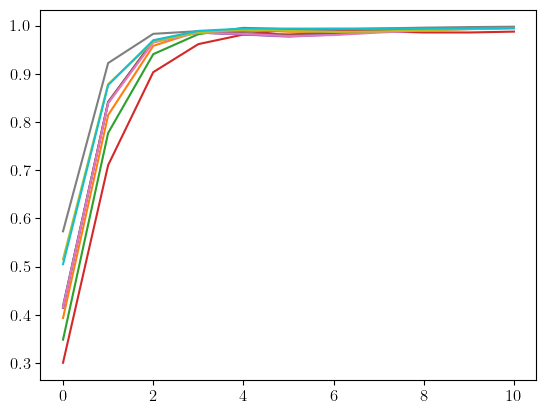

In [38]:
fig, ax = plt.subplots()
for i in range(A_diagonals.shape[1]):
    ax.plot(A_diagonals[:,i])

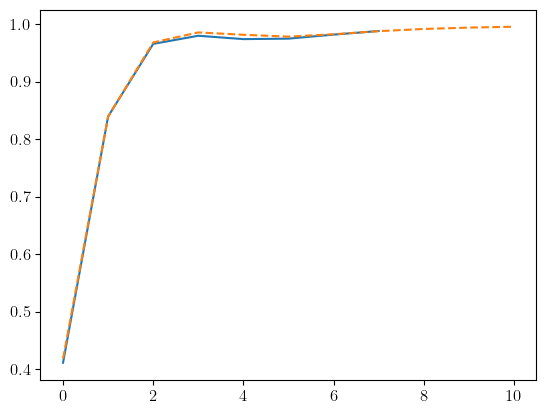

In [39]:
fig, ax = plt.subplots()
ax.plot(A_corrs)
ax.plot(A_diagonals[:,0], ls='--')

In [40]:
phi_diagonals = phi_diagonals[:,1:]

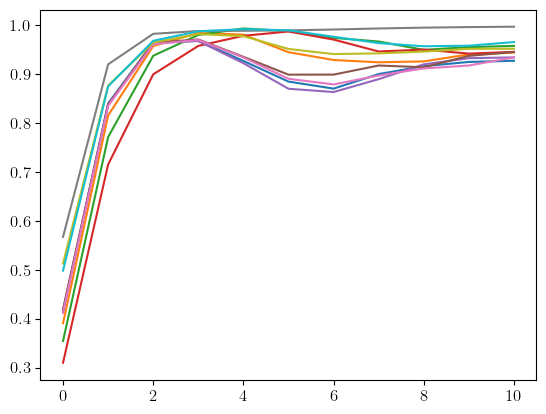

In [41]:
fig, ax = plt.subplots()

for i in range(phi_diagonals.shape[1]):
    ax.plot(phi_diagonals[:,i])